In [1]:
# enabling 3rd party widgets
# from google.colab import output
# output.enable_custom_widget_manager()
# output.disable_custom_widget_manager()

# interactive 3D plot
# !pip install ipympl
# %matplotlib widget

In [2]:
import os
import math
from collections import OrderedDict
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg

import time as time
import platform as platform

import tensorflow as tf
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.regularizers import L2
from keras.engine import data_adapter
import h5py

tf.keras.backend.set_floatx('float32')

plt.rcParams.update({
    "text.usetex":True,
    "font.family":"serif"
})

In [3]:
colab_flag = False
FTYPE = np.float32
ITYPE = np.int32

array = np.array
float32 = np.float32
int32 = np.int32
float64 = np.float64
int64 = np.int64

strategy = None
# strategy = tf.distribute.MirroredStrategy()

In [4]:
current_sys = platform.system()

if current_sys == 'Windows':
    dir_sep = '\\'
else:
    dir_sep = '/'

In [5]:
if colab_flag == True:
    from google.colab import drive
    drive.mount('/content/drive')
    os.chdir('/content/drive/MyDrive/Github/MLROM/KS/')

In [6]:
print(os.getcwd())

/home/rkaushik/Documents/Thesis/MLROM/new_lorenz


In [7]:
from tools.misc_tools import create_data_for_RNN, mytimecallback, SaveLosses, plot_losses, plot_reconstructed_data_KS, plot_latent_states_KS , readAndReturnLossHistories, plot_histogram_and_save

from tools.ae_v2 import Autoencoder

from tools.GRU_AR_v1 import AR_RNN_GRU as AR_RNN
# from tools.LSTM_AR_v1 import AR_RNN_LSTM as AR_RNN
# from tools.SimpleRNN_AR_v1 import AR_RNN_SimpleRNN as AR_RNN

from tools.AEGRU_AR_v1 import AR_AERNN_GRU as AR_AERNN
# from tools.AELSTM_AR_v1 import AR_AERNN_LSTM as AR_AERNN
# from tools.AESimpleRNN_AR_v1 import AR_AERNN_SimpleRNN as AR_AERNN

from tools.trainAERNN import trainAERNN

In [8]:
behaviour = 'initialiseAndTrainFromScratch'
# behaviour = 'loadCheckpoin?tAndContinueTraining'
# behaviour = 'loadFinalNetAndPlot'

In [9]:
gpus = tf.config.list_physical_devices('GPU')
print(gpus)

if colab_flag == False:
    if strategy is None:
        if gpus:
            gpu_to_use = 0
            tf.config.set_visible_devices(gpus[gpu_to_use], 'GPU')
    logical_devices = tf.config.list_logical_devices('GPU')
    print(logical_devices)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
[LogicalDevice(name='/device:GPU:0', device_type='GPU')]


2023-07-14 09:15:37.828040: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-14 09:15:37.861190: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-14 09:15:37.861400: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-14 09:15:37.862254: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropri

In [10]:
# print(tf.test.gpu_device_name())
print(tf.config.list_physical_devices())
print('')
print(tf.config.list_logical_devices())
print('')
print(tf.__version__)

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

[LogicalDevice(name='/device:CPU:0', device_type='CPU'), LogicalDevice(name='/device:GPU:0', device_type='GPU')]

2.8.1


# KS System

In [11]:
# setting up params (and saving, if applicable)
from numpy import *

if behaviour == 'initialiseAndTrainFromScratch':
    # RNN directory
    dir_name_rnn = os.getcwd()+'/saved_rnn/rnn_008'

    # making AR-RNN save directory
    dir_name_ARrnn = os.getcwd() + dir_sep + 'saved_AR_AERNN_rnn'
    if not os.path.isdir(dir_name_ARrnn):
        os.makedirs(dir_name_ARrnn)

    counter = 0
    while True:
        dir_check = 'AR_rnn_' + str(counter).zfill(3)
        if os.path.isdir(dir_name_ARrnn + dir_sep + dir_check):
            counter += 1
        else:
            break

    dir_name_ARrnn = dir_name_ARrnn + dir_sep + dir_check
    os.makedirs(dir_name_ARrnn)
    os.makedirs(dir_name_ARrnn+dir_sep+'plots')
    
    # reading RNN paramaters
    with open(dir_name_rnn + '/RNN_specific_data.txt') as f:
        lines = f.readlines()

    params_rnn_dict = eval(''.join(lines))

    dt_rnn = params_rnn_dict['dt_rnn']
    return_params_arr = params_rnn_dict['return_params_arr']
    params = params_rnn_dict['params']
    try:
        normalize_dataset = params_rnn_dict['normalize_dataset']
    except:
        print("'normalize_dataset' not present in rnn_specific_data, set to False.")
        normalize_dataset = False
    try:
        stddev_multiplier = params_rnn_dict['stddev_multiplier']
    except:
        print("'stddev_multiplier' not present in RNN_specific_data, set to None.")
        stddev_multiplier = None
    try:
        skip_intermediate = params_rnn_dict['skip_intermediate']
    except:
        print("'skip_intermediate' not present in RNN_specific_data, set to 1.")
        skip_intermediate = 1
    try:
        normalization_type = params_rnn_dict['normalization_type']
    except:
        print("'normalization_type' not present in RNN_specific_data, set to 'stddev'.")
        normalization_type = 'stddev'
    try:
        dense_layer_act_func = params_rnn_dict['dense_layer_act_func']
    except:
        print("'dense_layer_act_func' not present in RNN_specific_data, set to 'linear'.")
        dense_layer_act_func = 'linear'
    try:
        stateful = params_rnn_dict['stateful']
    except:
        print("'stateful' not present in RNN_specific_data, set to True.")
        stateful = True
    try:
        use_learnable_state = params_rnn_dict['use_learnable_state']
    except:
        print("'use_learnable_state' not present in RNN_specific_data, set to False.")
        use_learnable_state = False
    try:
        use_weights_post_dense = params_rnn_dict['use_weights_post_dense']
    except:
        print("'use_weights_post_dense' not present in RNN_specific_data, set to False.")
        use_weights_post_dense = False
        
    
    # training params
    with open(dir_name_rnn + dir_sep + 'training_specific_params.txt') as f:
        lines = f.readlines()

    tparams_dict = eval(''.join(lines))

    prng_seed = tparams_dict['prng_seed']
    train_split = tparams_dict['train_split']
    val_split = tparams_dict['val_split']
    batch_size = tparams_dict['batch_size']
    try:
        fRMS = tparams_dict['fRMS']
    except:
        fRMS = 0.0

    loss_weights = 0.98
else:
    # AR-RNN directory
    dir_name_ARrnn = os.getcwd()+'/saved_AR_AERNN_rnn/AR_AErnn_000'

    # reading AR-RNN parameters
    with open(dir_name_ARrnn + '/AR_rnn_specific_data.txt') as f:
        lines = f.readlines()
    
    params_AR_rnn_dict = eval(''.join(lines))

    dir_name_rnn = params_AR_rnn_dict['dir_name_rnn']
    rnn_idx = dir_name_rnn[-3:]
    dir_name_rnn = os.getcwd()+'/saved_rnn/rnn_'+rnn_idx

    dt_rnn = params_AR_rnn_dict['dt_rnn']
    T_sample_input = params_AR_rnn_dict['T_sample_input']
    T_sample_output = params_AR_rnn_dict['T_sample_output']
    T_offset = params_AR_rnn_dict['T_offset']
    return_params_arr = params_AR_rnn_dict['return_params_arr']
    params = params_AR_rnn_dict['params']
    try:
        normalize_dataset = params_AR_rnn_dict['normalize_dataset']
    except:
        print("'normalize_dataset' not present in AR_rnn_specific_data, set to False.")
        normalize_dataset = False
    try:
        stddev_multiplier = params_AR_rnn_dict['stddev_multiplier']
    except:
        print("'stddev_multiplier' not present in RNN_specific_data, set to None.")
        stddev_multiplier = None
    try:
        skip_intermediate = params_AR_rnn_dict['skip_intermediate']
    except:
        print("'skip_intermediate' not present in RNN_specific_data, set to 1.")
        skip_intermediate = 1
    try:
        use_ae_data = params_AR_rnn_dict['use_ae_data']
    except:
        print("'use_ae_data' not present in RNN_specific_data, set to True.")
        use_ae_data = True

    # training params
    with open(dir_name_ARrnn + dir_sep + 'training_specific_params.txt') as f:
        lines = f.readlines()

    tparams_dict = eval(''.join(lines))

    learning_rate_list = tparams_dict['learning_rate_list']
    epochs = tparams_dict['epochs']
    patience = tparams_dict['patience']
    min_delta = tparams_dict['min_delta']
    prng_seed = tparams_dict['prng_seed']
    train_split = tparams_dict['train_split']
    val_split = tparams_dict['val_split']
    batch_size = tparams_dict['batch_size']
    try:
        fRMS = tparams_dict['fRMS']
    except:
        fRMS = 0.0
    try:
        loss_weights = tparams_dict['loss_weights']
    except:
        loss_weights = None
    if 'freeze_layers' in tparams_dict.keys():
        freeze_layers = tparams_dict['freeze_layers']
    else:
        freeze_layers = None
    if 'clipnorm' in tparams_dict.keys():
        clipnorm = tparams_dict['clipnorm']
    else:
        clipnorm = None
    


# reading stddev
with open(dir_name_rnn + '/final_net/final_net_class_dict.txt') as f:
    lines = f.readlines()
finalnet_dict = eval(''.join(lines))
stddev = finalnet_dict['stddev']
# stddev = 0.0

# reading RNN normalization constants
normalization_arr_rnn = None
if normalize_dataset == True:
    with open(dir_name_rnn + '/final_net/rnn_normalization.txt') as f:
        lines = f.readlines()
    normarr_rnn_dict = eval(''.join(lines))
    normalization_arr_rnn = normarr_rnn_dict['normalization_arr']

if os.path.exists(dir_name_rnn+dir_sep+'normalization_data.npz'):
    with np.load(dir_name_rnn+dir_sep+'normalization_data.npz', allow_pickle=True) as fl:
        normalization_arr_rnn = fl['normalization_arr'][0]

# reading AE directory
with open(dir_name_rnn + '/sim_data_AE_params.txt') as f:
    lines = f.readlines()

params_dict = eval(''.join(lines))

dir_name_ae = params_dict['dir_name_ae']
ae_idx = dir_name_ae[-3:]
dir_name_ae = os.getcwd()+'/saved_ae/ae_'+ae_idx
try:
    use_ae_data = params_dict['use_ae_data']
except:
    print("'use_ae_data' not present in sim_data_AE_params, set to True.")
    use_ae_data = True

# reading simulation parameters
with open(dir_name_ae + dir_sep + 'ae_data.txt') as f:
    lines = f.readlines()
params_dict = eval(''.join(lines))
data_dir_idx = params_dict['data_dir_idx']
normalizeforae_flag = params_dict['normalizeforae_flag']
normalization_constant_arr_aedata = params_dict['normalization_constant_arr_aedata']
if os.path.exists(dir_name_ae+dir_sep+'normalization_data.npz'):
    with np.load(dir_name_ae+dir_sep+'normalization_data.npz', allow_pickle=True) as fl:
        normalization_constant_arr_aedata = fl['normalization_constant_arr_aedata'][0]
try:
    ae_data_with_params = params_dict['ae_data_with_params']
except:
    print("'ae_data_with_params' not present in RNN_specific_data, set to True.")
    ae_data_with_params = True

print('dir_name_AR_AErnn:', dir_name_ARrnn)
print('dir_name_rnn:', dir_name_rnn)
print('dir_name_ae:', dir_name_ae)
print('data_dir_idx:', data_dir_idx)

# loading data
dir_name_data = os.getcwd() + dir_sep + 'saved_data' + dir_sep + 'data_' + data_dir_idx
    
with open(dir_name_data + dir_sep + 'sim_data_params.txt') as f:
    lines = f.readlines()
params_dict = eval(''.join(lines))
params_mat = params_dict['params_mat']
# init_state = params_dict['init_state']
t0 = params_dict['t0']
T = params_dict['T']
delta_t = params_dict['delta_t']
return_params_arr = params_dict['return_params_arr']
normalize_flag_ogdata = params_dict['normalize_flag']
print('normalize_flag_ogdata:', normalize_flag_ogdata)
alldata_withparams_flag = params_dict['alldata_withparams_flag']

with np.load(dir_name_data+dir_sep+'data.npz', allow_pickle=True) as fl:
    all_data = fl['all_data'].astype(FTYPE)
    boundary_idx_arr = fl['boundary_idx_arr']
    normalization_constant_arr_ogdata = fl['normalization_constant_arr'][0]
    initial_t0 = fl['initial_t0']
    init_state_mat = fl['init_state_mat']

    lyapunov_spectrum_mat = fl['lyapunov_spectrum_mat']


test_split = 1 - train_split - val_split

# setting seed for PRNGs
np.random.seed(prng_seed)
tf.random.set_seed(prng_seed)

dir_name_AR_AErnn: /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_AR_AERNN_rnn/AR_rnn_008
dir_name_rnn: /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_rnn/rnn_008
dir_name_ae: /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae/ae_024
data_dir_idx: 010
normalize_flag_ogdata: False


In [12]:
lyapunov_time_arr = np.empty(shape=lyapunov_spectrum_mat.shape[0], dtype=FTYPE)
for i in range(lyapunov_spectrum_mat.shape[0]):
    lyapunov_time_arr[i] = 1/lyapunov_spectrum_mat[i, 0]
    print('Case : {}, lyapunov exponent : {}, lyapunov time : {}s'.format(i+1, lyapunov_spectrum_mat[i, 0], lyapunov_time_arr[i]))

Case : 1, lyapunov exponent : 0.9058021372262592, lyapunov time : 1.1039938926696777s


In [13]:
# delaing with normalizing the data before feeding into autoencoder
num_params = params_mat.shape[1]
og_vars = all_data.shape[1]
if alldata_withparams_flag == True:
    og_vars -= num_params

# if use_ae_data == True:
#     if ae_data_with_params == True and alldata_withparams_flag == False:
#         new_all_data = np.empty(shape=(all_data.shape[0], og_vars+num_params), dtype=FTYPE)
#         new_all_data[:, 0:og_vars] = all_data[:, 0:og_vars]
#         del(all_data)
#         all_data = new_all_data
#         prev_idx = 0
#         for i in range(boundary_idx_arr.shape[0]):
#             all_data[prev_idx:boundary_idx_arr[i], num_params:] = params_mat[i]
#             prev_idx = boundary_idx_arr[i]

#     if normalizeforae_flag == True:
#         for i in range(all_data.shape[1]):
#             all_data[:, i] -= normalization_constant_arr_aedata[0, i]
#             all_data[:, i] /= normalization_constant_arr_aedata[1, i]

#     if ae_data_with_params == False:
#         all_data = all_data[:, 0:og_vars]
# else:
#     # using raw data, neglecting the params attached (if any)
#     all_data = all_data[:, 0:og_vars]

if use_ae_data == True and ae_data_with_params == False:
    all_data = all_data[:, 0:og_vars]
else:
    all_data = all_data[:, 0:og_vars]
    
normalization_constant_arr_aedata = normalization_constant_arr_aedata[:, 0:all_data.shape[1]]

# Autoencoder

In [14]:
# if use_ae_data == True:
#     load_file = dir_name_ae+dir_sep+'final_net'+dir_sep+'final_net_class_dict.txt'
#     wt_file = dir_name_ae+dir_sep+'final_net'+dir_sep+'final_net_ae_weights.h5'

In [15]:
# if use_ae_data == True:
#     ae_net = Autoencoder(all_data.shape[1], load_file=load_file)
#     ae_net.load_weights_from_file(wt_file)

# GRU

In [16]:
if behaviour == 'initialiseAndTrainFromScratch':
    # RNN data parameters
    num_lyaptimesteps_totrain = np.array([
        5, 
        10,
        15,
        20,
        # 70,
    ])*dt_rnn/np.mean(lyapunov_time_arr)
    num_timesteps_warmup = 1*np.mean(lyapunov_time_arr)/dt_rnn
    T_sample_input = num_timesteps_warmup*dt_rnn
    T_sample_output = num_lyaptimesteps_totrain*np.mean(lyapunov_time_arr)
    T_offset = T_sample_input
    skip_intermediate = 'full sample'
    stateful = True
    if return_params_arr != False:
        params = params_arr
    else:
        params = None

    # saving AR RNN specific data
    AR_RNN_specific_data = {
        'dt_rnn':dt_rnn,
        'T_sample_input':T_sample_input,
        'T_sample_output':T_sample_output,
        'T_offset':T_offset,
        'boundary_idx_arr':boundary_idx_arr,
        'delta_t':delta_t,
        'params':params,
        'return_params_arr':return_params_arr,
        'normalize_dataset':normalize_dataset,
        'num_lyaptimesteps_totrain':num_lyaptimesteps_totrain,
        'num_timesteps_warmup':num_timesteps_warmup,
        'dir_name_rnn':dir_name_rnn,
        'dir_name_ae':dir_name_ae,
        'stddev_multiplier':stddev_multiplier,
        'skip_intermediate':skip_intermediate,
        'module':AR_RNN.__module__,
        'normalization_type':normalization_type,
        'use_ae_data':use_ae_data,
        'stateful':stateful,
    }

    with open(dir_name_ARrnn+dir_sep+'AR_RNN_specific_data.txt', 'w') as f:
        f.write(str(AR_RNN_specific_data))

In [17]:
# setting up training params
if behaviour == 'initialiseAndTrainFromScratch':
    learning_rate_list = [
        [1e-3, 5e-4, 1e-4],
        [1e-4, 5e-5, 1e-5],
        [1e-5, 5e-6, 1e-6],
        [1e-6, 5e-7, 1e-7],
        # [5e-7],
    ]
    epochs = [
        [200]*len(learning_rate_list[0]),
        [200]*len(learning_rate_list[1]),
        [200]*len(learning_rate_list[2]),
        [200]*len(learning_rate_list[3]),
        # [1000],
    ]
    patience = [
        [10]*len(learning_rate_list[0]),
        [10]*len(learning_rate_list[1]),
        [10]*len(learning_rate_list[2]),
        [10]*len(learning_rate_list[3]),
        # [50],
    ] # parameter for early stopping
    min_delta = 5e-6  # parameter for early stopping
    lambda_reg = 5e-7  # weight for regularizer
    covmat_lmda = 1e-4  # weight for the covmat loss

    if loss_weights is None:
        loss_weights = 1.0
        
    freeze_layers = [
        [],
        [],
        [],
        [],
        [],
    ]
    
    clipnorm = None #1.0
    batch_size = [
        32,
        32,
        32,
        32,
        # 32,
    ]
    
    # saving training params
    training_specific_params = {
        'learning_rate_list':learning_rate_list,
        'epochs':epochs,
        'patience':patience,
        'min_delta':min_delta,
        'prng_seed':prng_seed,
        'train_split':train_split,
        'val_split':val_split,
        'batch_size':batch_size,
        'fRMS':fRMS,
        'loss_weights':loss_weights,
        'stddev':stddev,
        'covmat_lmda':covmat_lmda,
        'freeze_layers':freeze_layers,
        'clipnorm':clipnorm,
    }

    with open(dir_name_ARrnn+dir_sep+'training_specific_params.txt', 'w') as f:
        f.write(str(training_specific_params))
    
    np.savez(
        dir_name_ARrnn+dir_sep+'normalization_data',
        normalization_arr=[normalization_arr_rnn],
    )

In [18]:
if behaviour == 'initialiseAndTrainFromScratch':
    load_file_rnn = dir_name_rnn + '/final_net/final_net_class_dict.txt'
    wt_file_rnn = dir_name_rnn+'/final_net/final_net_gru_weights.h5'
    
    load_file_ae = dir_name_ae+'/final_net/final_net_class_dict.txt'
    wt_file_ae = dir_name_ae+'/final_net/final_net_ae_weights.h5'



********************************************************************************
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> num_outsteps : 5 <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
********************************************************************************


clipnorm : None, global_clipnorm : None
82/82 [==============================] - 4s 15ms/step - loss: 0.1972 - mse: 0.0233 - NMSE: 0.2107 - NMSE_wt: 0.1971 - covmat_fro_loss: 0.0000e+00 - global_gradnorm: 0.0000e+00
baseline : 1.9706E-01


--------------------------------------------------------------------------------

---------------------------- LEARNING RATE : 0.001 -----------------------------

--------------------------------------------------------------------------------


Epoch 1/200
655/656 [============================>.] - ETA: 0s - loss: 0.1085 - mse: 0.0127 - NMSE: 0.1151 - NMSE_wt: 0.1084 - covmat_fro_loss: 2.5898e-04 - global_gradnorm: 38.3221 - tot_time: 0h 0m 29.3s

Epoch 1: val_NMSE_wt improved from 0.19706 to 0.03468, savi

Epoch 11/200
655/656 [============================>.] - ETA: 0s - loss: 0.0459 - mse: 0.0053 - NMSE: 0.0484 - NMSE_wt: 0.0456 - covmat_fro_loss: 1.9014e-04 - global_gradnorm: 7.0866 - tot_time: 0h 4m 4.0s

Epoch 11: val_NMSE_wt did not improve from 0.01669
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/LossHistoriesCheckpoint-5_outsteps
656/656 [==============================] - 22s 33ms/step - loss: 0.0458 - mse: 0.0053 - NMSE: 0.0483 - NMSE_wt: 0.0455 - covmat_fro_loss: 1.8995e-04 - global_gradnorm: 7.0755 - val_loss: 0.0239 - val_mse: 0.0027 - val_NMSE: 0.0249 - val_NMSE_wt: 0.0235 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 12/200
656/656 [==============================] - ETA: 0s - loss: 0.0409 - mse: 0.0047 - NMSE: 0.0430 - NMSE_wt: 0.0405 - covmat_fro_loss: 1.8446e-04 - global_gradnorm: 6.1492 - tot_time: 0h 4m 24.9s

Epoch 12: val_NMSE_wt did not improve from 0.01669
 - saving 

Epoch 8/200
654/656 [============================>.] - ETA: 0s - loss: 0.0267 - mse: 0.0031 - NMSE: 0.0281 - NMSE_wt: 0.0265 - covmat_fro_loss: 1.4322e-04 - global_gradnorm: 8.2400 - tot_time: 0h 7m 58.6s

Epoch 8: val_NMSE_wt did not improve from 0.01350
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/LossHistoriesCheckpoint-5_outsteps
656/656 [==============================] - 22s 33ms/step - loss: 0.0267 - mse: 0.0031 - NMSE: 0.0281 - NMSE_wt: 0.0265 - covmat_fro_loss: 1.4317e-04 - global_gradnorm: 8.2146 - val_loss: 0.0694 - val_mse: 0.0081 - val_NMSE: 0.0737 - val_NMSE_wt: 0.0692 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 9/200
656/656 [==============================] - ETA: 0s - loss: 0.0258 - mse: 0.0030 - NMSE: 0.0272 - NMSE_wt: 0.0256 - covmat_fro_loss: 1.4213e-04 - global_gradnorm: 7.2121 - tot_time: 0h 8m 20.1s

Epoch 9: val_NMSE_wt did not improve from 0.01350
 - saving los

Epoch 19/200
656/656 [==============================] - ETA: 0s - loss: 0.0215 - mse: 0.0025 - NMSE: 0.0225 - NMSE_wt: 0.0212 - covmat_fro_loss: 1.1832e-04 - global_gradnorm: 6.1362 - tot_time: 0h 11m 59.3s

Epoch 19: val_NMSE_wt did not improve from 0.01111
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/LossHistoriesCheckpoint-5_outsteps
656/656 [==============================] - 22s 33ms/step - loss: 0.0215 - mse: 0.0025 - NMSE: 0.0225 - NMSE_wt: 0.0212 - covmat_fro_loss: 1.1837e-04 - global_gradnorm: 6.1314 - val_loss: 0.0303 - val_mse: 0.0035 - val_NMSE: 0.0320 - val_NMSE_wt: 0.0300 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 20/200
655/656 [============================>.] - ETA: 0s - loss: 0.0355 - mse: 0.0041 - NMSE: 0.0374 - NMSE_wt: 0.0352 - covmat_fro_loss: 1.5309e-04 - global_gradnorm: 7.6045 - tot_time: 0h 12m 21.0s

Epoch 20: val_NMSE_wt did not improve from 0.01111
 - savi

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/LossHistoriesCheckpoint-5_outsteps
656/656 [==============================] - 22s 33ms/step - loss: 0.0084 - mse: 9.4076e-04 - NMSE: 0.0085 - NMSE_wt: 0.0081 - covmat_fro_loss: 7.2287e-05 - global_gradnorm: 2.8543 - val_loss: 0.0097 - val_mse: 0.0011 - val_NMSE: 0.0099 - val_NMSE_wt: 0.0094 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 5/200
656/656 [==============================] - ETA: 0s - loss: 0.0089 - mse: 0.0010 - NMSE: 0.0091 - NMSE_wt: 0.0087 - covmat_fro_loss: 7.2515e-05 - global_gradnorm: 3.0793 - tot_time: 0h 15m 58.4s

Epoch 5: val_NMSE_wt did not improve from 0.00846
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/LossHistoriesCheckpoint-5_outsteps
656/656 [==============================] - 22s 33ms/step - loss: 0.0089 - mse: 0.0010 - NMSE: 0.0091 - NMSE_wt

656/656 [==============================] - ETA: 0s - loss: 0.0087 - mse: 9.8428e-04 - NMSE: 0.0089 - NMSE_wt: 0.0084 - covmat_fro_loss: 7.5665e-05 - global_gradnorm: 3.8065 - tot_time: 0h 19m 29.7s

Epoch 15: val_NMSE_wt did not improve from 0.00662
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/LossHistoriesCheckpoint-5_outsteps
656/656 [==============================] - 21s 32ms/step - loss: 0.0087 - mse: 9.8428e-04 - NMSE: 0.0089 - NMSE_wt: 0.0084 - covmat_fro_loss: 7.5676e-05 - global_gradnorm: 3.8037 - val_loss: 0.0072 - val_mse: 8.0309e-04 - val_NMSE: 0.0073 - val_NMSE_wt: 0.0069 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 16/200
656/656 [==============================] - ETA: 0s - loss: 0.0082 - mse: 9.1894e-04 - NMSE: 0.0083 - NMSE_wt: 0.0079 - covmat_fro_loss: 7.2985e-05 - global_gradnorm: 3.4578 - tot_time: 0h 19m 50.3s

Epoch 16: val_NMSE_wt did not improve from 0.00662
 - s

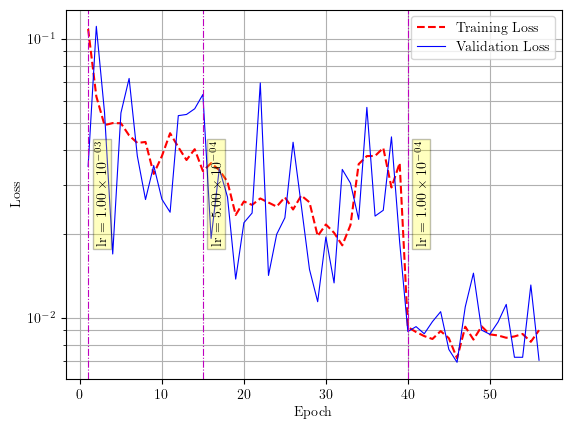

<Figure size 640x480 with 0 Axes>

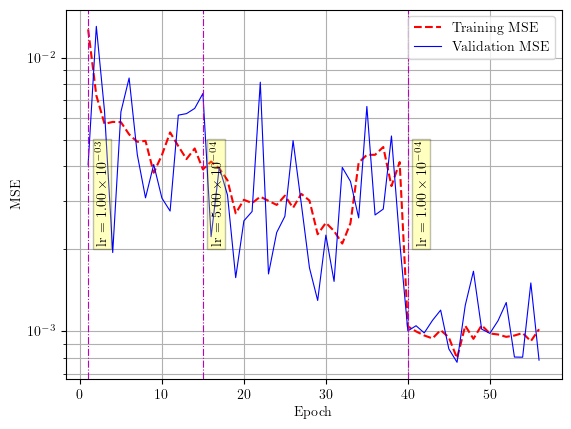

<Figure size 640x480 with 0 Axes>

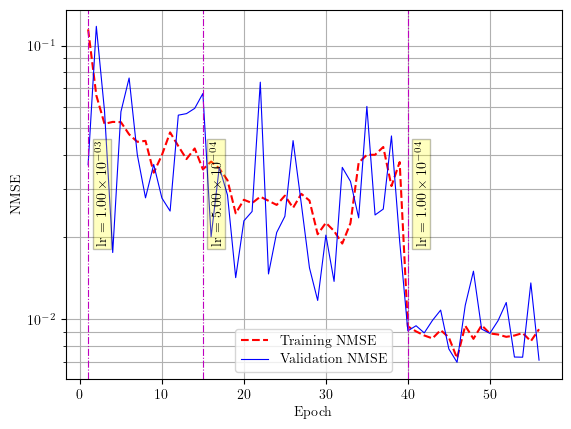

<Figure size 640x480 with 0 Axes>

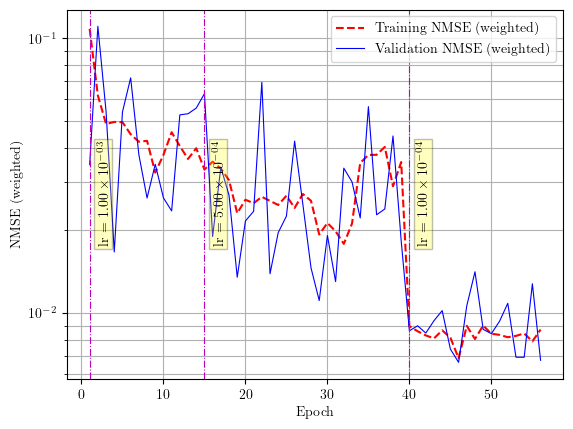

<Figure size 640x480 with 0 Axes>

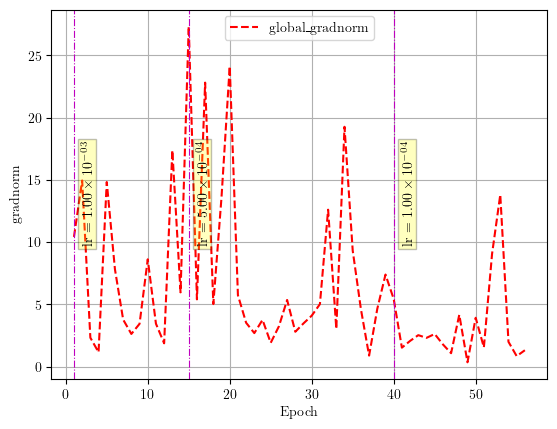



********************************************************************************
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> num_outsteps : 10 <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
********************************************************************************


clipnorm : None, global_clipnorm : 27.3
62/62 [==============================] - 5s 17ms/step - loss: 0.0393 - mse: 0.0050 - NMSE: 0.0453 - NMSE_wt: 0.0390 - covmat_fro_loss: 0.0000e+00 - global_gradnorm: 0.0000e+00
baseline : 3.8972E-02


--------------------------------------------------------------------------------

---------------------------- LEARNING RATE : 0.0001 ----------------------------

--------------------------------------------------------------------------------


Epoch 1/200
499/500 [============================>.] - ETA: 0s - loss: 0.0564 - mse: 0.0071 - NMSE: 0.0646 - NMSE_wt: 0.0561 - covmat_fro_loss: 1.9025e-04 - global_gradnorm: 21.4339 - tot_time: 0h 0m 38.0s

Epoch 1: val_NMSE_wt improved from 0.03897 to 0.03682, savi

Epoch 11/200
500/500 [==============================] - ETA: 0s - loss: 0.0609 - mse: 0.0076 - NMSE: 0.0692 - NMSE_wt: 0.0606 - covmat_fro_loss: 2.3049e-04 - global_gradnorm: 19.1770Restoring model weights from the end of the best epoch: 1.
 - tot_time: 0h 4m 53.1s

Epoch 11: val_NMSE_wt did not improve from 0.03682
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/LossHistoriesCheckpoint-10_outsteps
500/500 [==============================] - 25s 51ms/step - loss: 0.0609 - mse: 0.0076 - NMSE: 0.0692 - NMSE_wt: 0.0606 - covmat_fro_loss: 2.3046e-04 - global_gradnorm: 19.1670 - val_loss: 0.0467 - val_mse: 0.0058 - val_NMSE: 0.0530 - val_NMSE_wt: 0.0464 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 11: early stopping


--------------------------------------------------------------------------------

---------------------------- LEARNING RATE : 5e-05 -----------------------------

--------------

Epoch 10: early stopping


--------------------------------------------------------------------------------

---------------------------- LEARNING RATE : 1e-05 -----------------------------

--------------------------------------------------------------------------------


Epoch 1/200
500/500 [==============================] - ETA: 0s - loss: 0.0454 - mse: 0.0057 - NMSE: 0.0513 - NMSE_wt: 0.0451 - covmat_fro_loss: 2.1114e-04 - global_gradnorm: 17.3628 - tot_time: 0h 9m 33.9s

Epoch 1: val_NMSE_wt did not improve from 0.03682
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/LossHistoriesCheckpoint-10_outsteps
500/500 [==============================] - 26s 51ms/step - loss: 0.0454 - mse: 0.0057 - NMSE: 0.0513 - NMSE_wt: 0.0451 - covmat_fro_loss: 2.1113e-04 - global_gradnorm: 17.3826 - val_loss: 0.0375 - val_mse: 0.0047 - val_NMSE: 0.0422 - val_NMSE_wt: 0.0372 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0

499/500 [============================>.] - ETA: 0s - loss: 0.0414 - mse: 0.0052 - NMSE: 0.0467 - NMSE_wt: 0.0411 - covmat_fro_loss: 2.0445e-04 - global_gradnorm: 17.4365 - tot_time: 0h 13m 48.7s

Epoch 11: val_NMSE_wt did not improve from 0.03434
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/LossHistoriesCheckpoint-10_outsteps
500/500 [==============================] - 24s 48ms/step - loss: 0.0414 - mse: 0.0052 - NMSE: 0.0468 - NMSE_wt: 0.0411 - covmat_fro_loss: 2.0448e-04 - global_gradnorm: 17.4407 - val_loss: 0.0349 - val_mse: 0.0043 - val_NMSE: 0.0392 - val_NMSE_wt: 0.0346 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 12/200
500/500 [==============================] - ETA: 0s - loss: 0.0414 - mse: 0.0052 - NMSE: 0.0468 - NMSE_wt: 0.0412 - covmat_fro_loss: 2.0269e-04 - global_gradnorm: 17.0430 - tot_time: 0h 14m 14.7s

Epoch 12: val_NMSE_wt did not improve from 0.03434
 - saving loss h

Epoch 22/200
500/500 [==============================] - ETA: 0s - loss: 0.0387 - mse: 0.0048 - NMSE: 0.0437 - NMSE_wt: 0.0385 - covmat_fro_loss: 1.9483e-04 - global_gradnorm: 17.5850 - tot_time: 0h 18m 21.6s

Epoch 22: val_NMSE_wt did not improve from 0.03183
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/LossHistoriesCheckpoint-10_outsteps
500/500 [==============================] - 24s 49ms/step - loss: 0.0387 - mse: 0.0048 - NMSE: 0.0437 - NMSE_wt: 0.0385 - covmat_fro_loss: 1.9476e-04 - global_gradnorm: 17.5616 - val_loss: 0.0354 - val_mse: 0.0044 - val_NMSE: 0.0399 - val_NMSE_wt: 0.0351 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 23/200
499/500 [============================>.] - ETA: 0s - loss: 0.0372 - mse: 0.0046 - NMSE: 0.0420 - NMSE_wt: 0.0369 - covmat_fro_loss: 1.9233e-04 - global_gradnorm: 17.5593 - tot_time: 0h 18m 46.1s

Epoch 23: val_NMSE_wt improved from 0.03183 to 0.03144

Epoch 33/200
500/500 [==============================] - ETA: 0s - loss: 0.0347 - mse: 0.0043 - NMSE: 0.0391 - NMSE_wt: 0.0344 - covmat_fro_loss: 1.8201e-04 - global_gradnorm: 17.2437 - tot_time: 0h 22m 58.6s

Epoch 33: val_NMSE_wt did not improve from 0.02990
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/LossHistoriesCheckpoint-10_outsteps
500/500 [==============================] - 25s 51ms/step - loss: 0.0347 - mse: 0.0043 - NMSE: 0.0391 - NMSE_wt: 0.0344 - covmat_fro_loss: 1.8208e-04 - global_gradnorm: 17.2638 - val_loss: 0.0305 - val_mse: 0.0038 - val_NMSE: 0.0342 - val_NMSE_wt: 0.0302 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 34/200
500/500 [==============================] - ETA: 0s - loss: 0.0344 - mse: 0.0043 - NMSE: 0.0388 - NMSE_wt: 0.0341 - covmat_fro_loss: 1.8141e-04 - global_gradnorm: 16.6211 - tot_time: 0h 23m 23.7s

Epoch 34: val_NMSE_wt improved from 0.02990 to 0.02971

Epoch 44/200
500/500 [==============================] - ETA: 0s - loss: 0.0332 - mse: 0.0041 - NMSE: 0.0374 - NMSE_wt: 0.0329 - covmat_fro_loss: 1.7656e-04 - global_gradnorm: 17.1517 - tot_time: 0h 27m 40.2s

Epoch 44: val_NMSE_wt did not improve from 0.02885
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/LossHistoriesCheckpoint-10_outsteps
500/500 [==============================] - 26s 51ms/step - loss: 0.0332 - mse: 0.0041 - NMSE: 0.0374 - NMSE_wt: 0.0329 - covmat_fro_loss: 1.7657e-04 - global_gradnorm: 17.1225 - val_loss: 0.0305 - val_mse: 0.0038 - val_NMSE: 0.0343 - val_NMSE_wt: 0.0302 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 45/200
500/500 [==============================] - ETA: 0s - loss: 0.0334 - mse: 0.0042 - NMSE: 0.0376 - NMSE_wt: 0.0331 - covmat_fro_loss: 1.7924e-04 - global_gradnorm: 17.3599 - tot_time: 0h 28m 5.8s

Epoch 45: val_NMSE_wt did not improve from 0.02885
 - s

Epoch 55/200
500/500 [==============================] - ETA: 0s - loss: 0.0319 - mse: 0.0040 - NMSE: 0.0359 - NMSE_wt: 0.0316 - covmat_fro_loss: 1.7810e-04 - global_gradnorm: 16.8904 - tot_time: 0h 32m 21.6s

Epoch 55: val_NMSE_wt did not improve from 0.02759
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/LossHistoriesCheckpoint-10_outsteps
500/500 [==============================] - 26s 52ms/step - loss: 0.0319 - mse: 0.0040 - NMSE: 0.0359 - NMSE_wt: 0.0316 - covmat_fro_loss: 1.7816e-04 - global_gradnorm: 16.8634 - val_loss: 0.0304 - val_mse: 0.0038 - val_NMSE: 0.0342 - val_NMSE_wt: 0.0301 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 56/200
500/500 [==============================] - ETA: 0s - loss: 0.0336 - mse: 0.0042 - NMSE: 0.0379 - NMSE_wt: 0.0333 - covmat_fro_loss: 1.7658e-04 - global_gradnorm: 16.9622 - tot_time: 0h 32m 47.8s

Epoch 56: val_NMSE_wt did not improve from 0.02759
 - 

<Figure size 640x480 with 0 Axes>

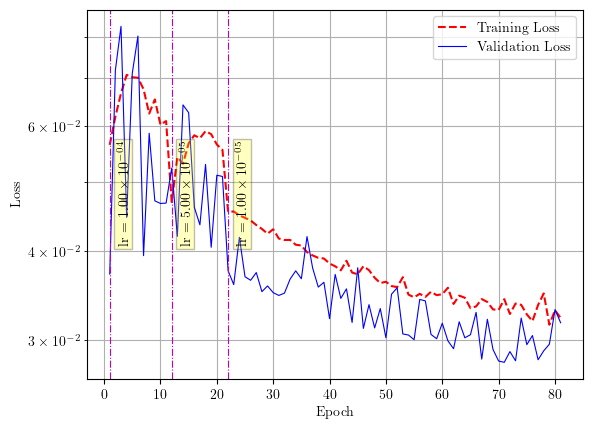

<Figure size 640x480 with 0 Axes>

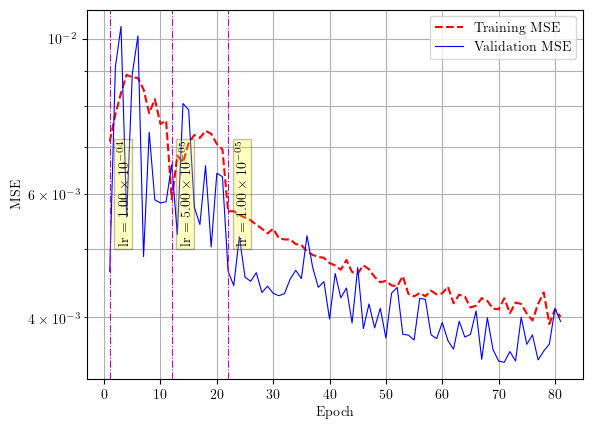

<Figure size 640x480 with 0 Axes>

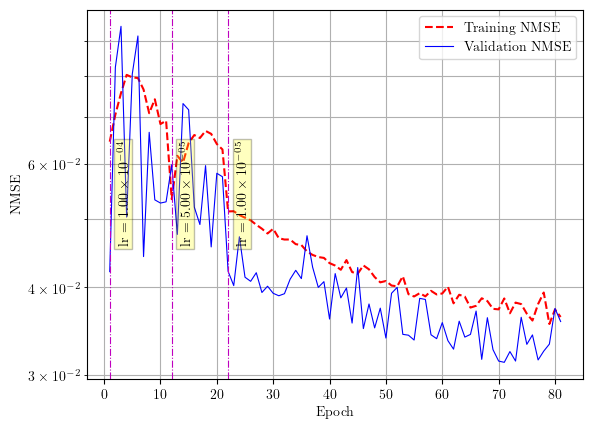

<Figure size 640x480 with 0 Axes>

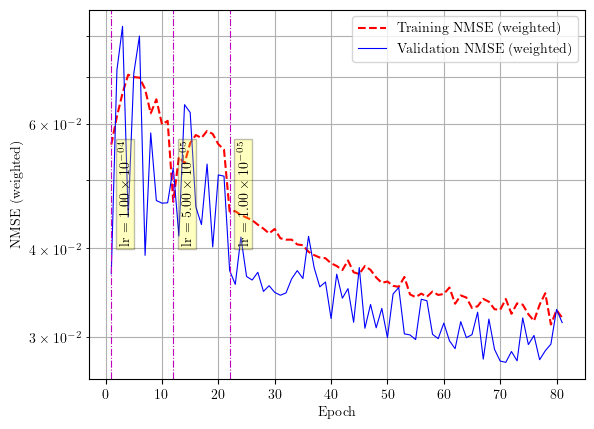

<Figure size 640x480 with 0 Axes>

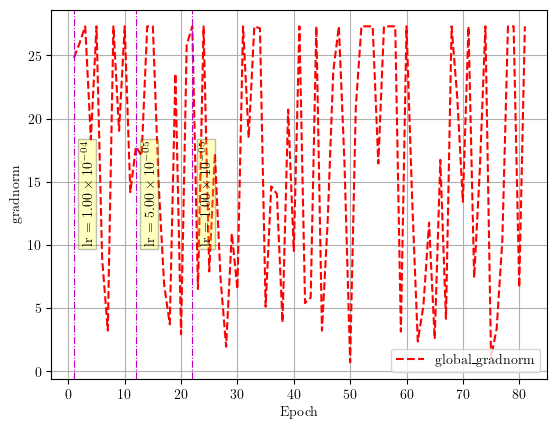



********************************************************************************
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> num_outsteps : 15 <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
********************************************************************************


clipnorm : None, global_clipnorm : 27.3
50/50 [==============================] - 7s 21ms/step - loss: 0.0937 - mse: 0.0129 - NMSE: 0.1167 - NMSE_wt: 0.0934 - covmat_fro_loss: 0.0000e+00 - global_gradnorm: 0.0000e+00
baseline : 9.3433E-02


--------------------------------------------------------------------------------

---------------------------- LEARNING RATE : 1e-05 -----------------------------

--------------------------------------------------------------------------------


Epoch 1/200
403/403 [==============================] - ETA: 0s - loss: 0.0846 - mse: 0.0115 - NMSE: 0.1046 - NMSE_wt: 0.0843 - covmat_fro_loss: 2.6558e-04 - global_gradnorm: 23.8758 - tot_time: 0h 0m 45.3s

Epoch 1: val_NMSE_wt did not improve from 0.09343
 - saving

Epoch 11/200
403/403 [==============================] - ETA: 0s - loss: 0.0733 - mse: 0.0099 - NMSE: 0.0896 - NMSE_wt: 0.0730 - covmat_fro_loss: 2.7292e-04 - global_gradnorm: 24.1883 - tot_time: 0h 5m 19.9s

Epoch 11: val_NMSE_wt did not improve from 0.07692
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/LossHistoriesCheckpoint-15_outsteps
403/403 [==============================] - 28s 69ms/step - loss: 0.0733 - mse: 0.0099 - NMSE: 0.0896 - NMSE_wt: 0.0730 - covmat_fro_loss: 2.7305e-04 - global_gradnorm: 24.1960 - val_loss: 0.0886 - val_mse: 0.0120 - val_NMSE: 0.1085 - val_NMSE_wt: 0.0884 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 12/200
403/403 [==============================] - ETA: 0s - loss: 0.0718 - mse: 0.0097 - NMSE: 0.0879 - NMSE_wt: 0.0715 - covmat_fro_loss: 2.7691e-04 - global_gradnorm: 23.5737 - tot_time: 0h 5m 47.7s

Epoch 12: val_NMSE_wt did not improve from 0.07692
 - sa

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/LossHistoriesCheckpoint-15_outsteps
403/403 [==============================] - 28s 69ms/step - loss: 0.0722 - mse: 0.0098 - NMSE: 0.0885 - NMSE_wt: 0.0719 - covmat_fro_loss: 2.6798e-04 - global_gradnorm: 23.1005 - val_loss: 0.0773 - val_mse: 0.0104 - val_NMSE: 0.0946 - val_NMSE_wt: 0.0770 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 9/200
403/403 [==============================] - ETA: 0s - loss: 0.0714 - mse: 0.0096 - NMSE: 0.0874 - NMSE_wt: 0.0711 - covmat_fro_loss: 2.6780e-04 - global_gradnorm: 23.7054 - tot_time: 0h 10m 21.8s

Epoch 9: val_NMSE_wt did not improve from 0.07630
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/LossHistoriesCheckpoint-15_outsteps
403/403 [==============================] - 28s 70ms/step - loss: 0.0714 - mse: 0.0096 - NMSE: 0.0874 - NMSE_wt

Epoch 19/200
403/403 [==============================] - ETA: 0s - loss: 0.0701 - mse: 0.0095 - NMSE: 0.0856 - NMSE_wt: 0.0698 - covmat_fro_loss: 2.7261e-04 - global_gradnorm: 23.0154 - tot_time: 0h 14m 57.1s

Epoch 19: val_NMSE_wt did not improve from 0.07125
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/LossHistoriesCheckpoint-15_outsteps
403/403 [==============================] - 28s 69ms/step - loss: 0.0701 - mse: 0.0095 - NMSE: 0.0856 - NMSE_wt: 0.0698 - covmat_fro_loss: 2.7253e-04 - global_gradnorm: 22.9901 - val_loss: 0.0742 - val_mse: 0.0100 - val_NMSE: 0.0904 - val_NMSE_wt: 0.0739 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 20/200
403/403 [==============================] - ETA: 0s - loss: 0.0694 - mse: 0.0094 - NMSE: 0.0848 - NMSE_wt: 0.0691 - covmat_fro_loss: 2.7449e-04 - global_gradnorm: 23.7130 - tot_time: 0h 15m 24.4s

Epoch 20: val_NMSE_wt did not improve from 0.07125
 - 

Epoch 30/200
403/403 [==============================] - ETA: 0s - loss: 0.0669 - mse: 0.0090 - NMSE: 0.0816 - NMSE_wt: 0.0666 - covmat_fro_loss: 2.7987e-04 - global_gradnorm: 23.1917 - tot_time: 0h 20m 1.3s

Epoch 30: val_NMSE_wt did not improve from 0.06956
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/LossHistoriesCheckpoint-15_outsteps
403/403 [==============================] - 28s 68ms/step - loss: 0.0669 - mse: 0.0090 - NMSE: 0.0816 - NMSE_wt: 0.0666 - covmat_fro_loss: 2.7976e-04 - global_gradnorm: 23.2019 - val_loss: 0.0718 - val_mse: 0.0097 - val_NMSE: 0.0876 - val_NMSE_wt: 0.0715 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 31/200
403/403 [==============================] - ETA: 0s - loss: 0.0654 - mse: 0.0088 - NMSE: 0.0796 - NMSE_wt: 0.0651 - covmat_fro_loss: 2.7756e-04 - global_gradnorm: 22.9194 - tot_time: 0h 20m 29.3s

Epoch 31: val_NMSE_wt did not improve from 0.06956
 - s

Epoch 41/200
403/403 [==============================] - ETA: 0s - loss: 0.0635 - mse: 0.0085 - NMSE: 0.0772 - NMSE_wt: 0.0632 - covmat_fro_loss: 2.8306e-04 - global_gradnorm: 23.5080 - tot_time: 0h 24m 58.3s

Epoch 41: val_NMSE_wt did not improve from 0.06637
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/LossHistoriesCheckpoint-15_outsteps
403/403 [==============================] - 27s 67ms/step - loss: 0.0635 - mse: 0.0085 - NMSE: 0.0772 - NMSE_wt: 0.0632 - covmat_fro_loss: 2.8303e-04 - global_gradnorm: 23.5174 - val_loss: 0.0730 - val_mse: 0.0098 - val_NMSE: 0.0891 - val_NMSE_wt: 0.0727 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 42/200
403/403 [==============================] - ETA: 0s - loss: 0.0635 - mse: 0.0085 - NMSE: 0.0772 - NMSE_wt: 0.0632 - covmat_fro_loss: 2.8274e-04 - global_gradnorm: 23.1691 - tot_time: 0h 25m 24.6s

Epoch 42: val_NMSE_wt did not improve from 0.06637
 - 

Epoch 52/200
403/403 [==============================] - ETA: 0s - loss: 0.0603 - mse: 0.0081 - NMSE: 0.0732 - NMSE_wt: 0.0600 - covmat_fro_loss: 2.8564e-04 - global_gradnorm: 22.8760 - tot_time: 0h 29m 53.7s

Epoch 52: val_NMSE_wt did not improve from 0.06454
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/LossHistoriesCheckpoint-15_outsteps
403/403 [==============================] - 27s 68ms/step - loss: 0.0603 - mse: 0.0081 - NMSE: 0.0732 - NMSE_wt: 0.0600 - covmat_fro_loss: 2.8567e-04 - global_gradnorm: 22.8869 - val_loss: 0.0661 - val_mse: 0.0088 - val_NMSE: 0.0802 - val_NMSE_wt: 0.0658 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 53/200
403/403 [==============================] - ETA: 0s - loss: 0.0607 - mse: 0.0081 - NMSE: 0.0737 - NMSE_wt: 0.0604 - covmat_fro_loss: 2.8715e-04 - global_gradnorm: 23.4550 - tot_time: 0h 30m 20.3s

Epoch 53: val_NMSE_wt did not improve from 0.06454
 - 

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/LossHistoriesCheckpoint-15_outsteps
403/403 [==============================] - 27s 68ms/step - loss: 0.0593 - mse: 0.0079 - NMSE: 0.0720 - NMSE_wt: 0.0590 - covmat_fro_loss: 2.7990e-04 - global_gradnorm: 22.5447 - val_loss: 0.0663 - val_mse: 0.0089 - val_NMSE: 0.0805 - val_NMSE_wt: 0.0660 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 8/200
403/403 [==============================] - ETA: 0s - loss: 0.0590 - mse: 0.0079 - NMSE: 0.0716 - NMSE_wt: 0.0587 - covmat_fro_loss: 2.7946e-04 - global_gradnorm: 22.5078 - tot_time: 0h 34m 49.8s

Epoch 8: val_NMSE_wt did not improve from 0.06366
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/LossHistoriesCheckpoint-15_outsteps
403/403 [==============================] - 27s 68ms/step - loss: 0.0590 - mse: 0.0079 - NMSE: 0.0716 - NMSE_wt

<Figure size 640x480 with 0 Axes>

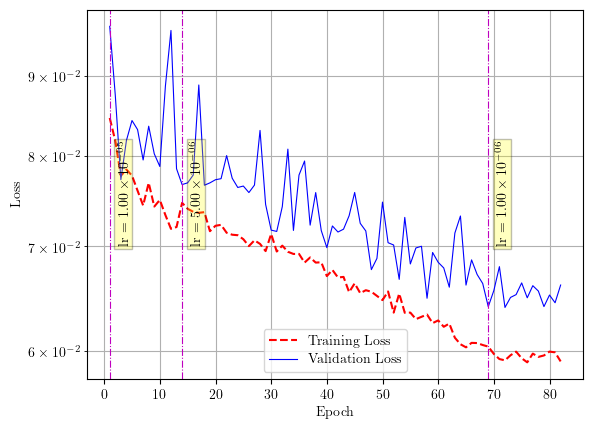

<Figure size 640x480 with 0 Axes>

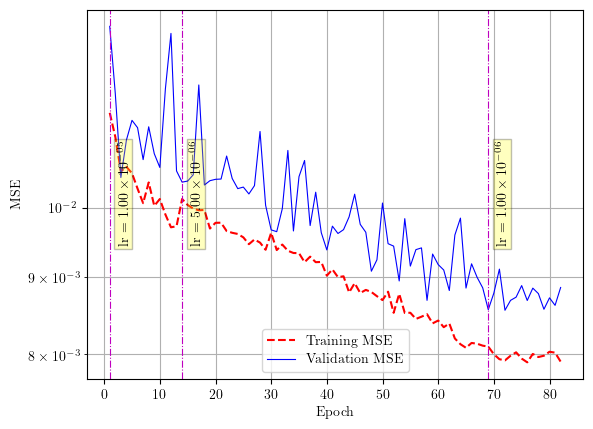

<Figure size 640x480 with 0 Axes>

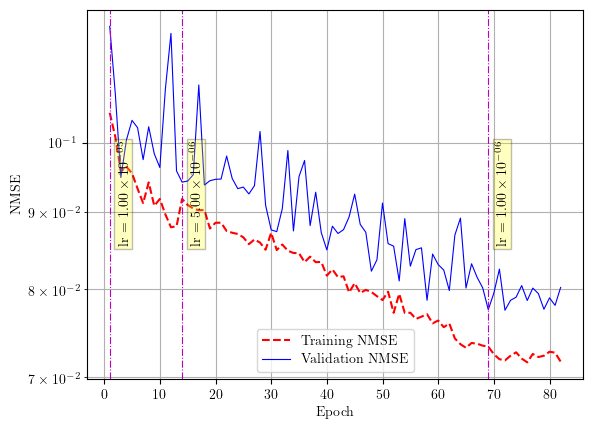

<Figure size 640x480 with 0 Axes>

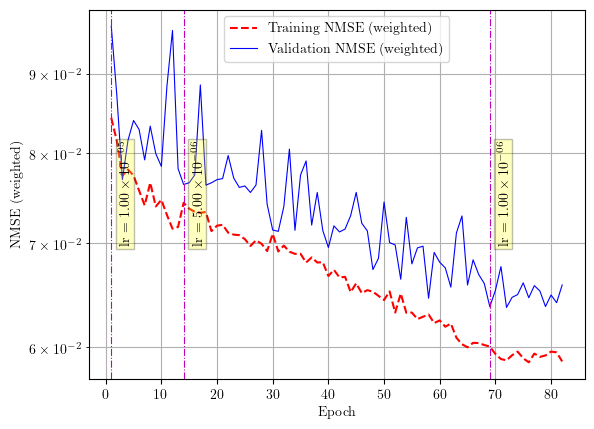

<Figure size 640x480 with 0 Axes>

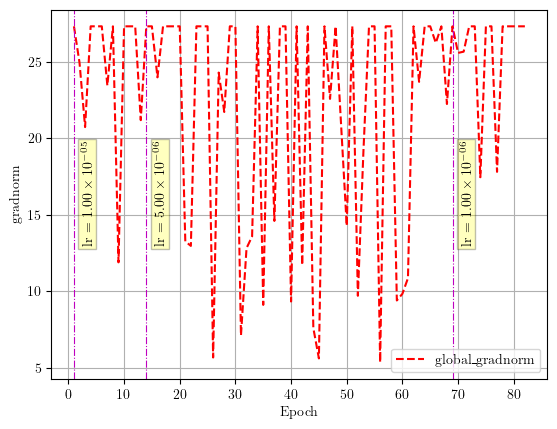



********************************************************************************
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> num_outsteps : 20 <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
********************************************************************************


clipnorm : None, global_clipnorm : 27.3
42/42 [==============================] - 9s 28ms/step - loss: 0.1025 - mse: 0.0149 - NMSE: 0.1353 - NMSE_wt: 0.1022 - covmat_fro_loss: 0.0000e+00 - global_gradnorm: 0.0000e+00
baseline : 1.0220E-01


--------------------------------------------------------------------------------

---------------------------- LEARNING RATE : 1e-06 -----------------------------

--------------------------------------------------------------------------------


Epoch 1/200
338/338 [==============================] - ETA: 0s - loss: 0.0946 - mse: 0.0138 - NMSE: 0.1252 - NMSE_wt: 0.0943 - covmat_fro_loss: 3.6797e-04 - global_gradnorm: 26.1182 - tot_time: 0h 0m 50.2s

Epoch 1: val_NMSE_wt improved from 0.10220 to 0.09783, savi

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/LossHistoriesCheckpoint-20_outsteps
338/338 [==============================] - 28s 83ms/step - loss: 0.0932 - mse: 0.0136 - NMSE: 0.1232 - NMSE_wt: 0.0929 - covmat_fro_loss: 3.6437e-04 - global_gradnorm: 25.6655 - val_loss: 0.0958 - val_mse: 0.0139 - val_NMSE: 0.1262 - val_NMSE_wt: 0.0955 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 11/200
338/338 [==============================] - ETA: 0s - loss: 0.0911 - mse: 0.0133 - NMSE: 0.1203 - NMSE_wt: 0.0908 - covmat_fro_loss: 3.6512e-04 - global_gradnorm: 25.7639 - tot_time: 0h 5m 29.5s

Epoch 11: val_NMSE_wt did not improve from 0.09501
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/LossHistoriesCheckpoint-20_outsteps
338/338 [==============================] - 28s 84ms/step - loss: 0.0911 - mse: 0.0133 - NMSE: 0.1203 - NMSE_w

338/338 [==============================] - ETA: 0s - loss: 0.0906 - mse: 0.0132 - NMSE: 0.1195 - NMSE_wt: 0.0903 - covmat_fro_loss: 3.6169e-04 - global_gradnorm: 25.6522 - tot_time: 0h 10m 5.5s

Epoch 21: val_NMSE_wt did not improve from 0.09329
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/LossHistoriesCheckpoint-20_outsteps
338/338 [==============================] - 27s 80ms/step - loss: 0.0906 - mse: 0.0132 - NMSE: 0.1195 - NMSE_wt: 0.0903 - covmat_fro_loss: 3.6161e-04 - global_gradnorm: 25.6571 - val_loss: 0.0960 - val_mse: 0.0139 - val_NMSE: 0.1262 - val_NMSE_wt: 0.0957 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 22/200
338/338 [==============================] - ETA: 0s - loss: 0.0908 - mse: 0.0132 - NMSE: 0.1199 - NMSE_wt: 0.0905 - covmat_fro_loss: 3.6008e-04 - global_gradnorm: 25.6702 - tot_time: 0h 10m 34.3s

Epoch 22: val_NMSE_wt did not improve from 0.09329
 - saving loss hi

Epoch 5/200
338/338 [==============================] - ETA: 0s - loss: 0.0908 - mse: 0.0132 - NMSE: 0.1198 - NMSE_wt: 0.0905 - covmat_fro_loss: 3.6292e-04 - global_gradnorm: 25.5105 - tot_time: 0h 15m 13.7s

Epoch 5: val_NMSE_wt did not improve from 0.09297
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/LossHistoriesCheckpoint-20_outsteps
338/338 [==============================] - 29s 84ms/step - loss: 0.0908 - mse: 0.0132 - NMSE: 0.1198 - NMSE_wt: 0.0905 - covmat_fro_loss: 3.6275e-04 - global_gradnorm: 25.5158 - val_loss: 0.0949 - val_mse: 0.0138 - val_NMSE: 0.1247 - val_NMSE_wt: 0.0946 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 6/200
338/338 [==============================] - ETA: 0s - loss: 0.0901 - mse: 0.0131 - NMSE: 0.1189 - NMSE_wt: 0.0898 - covmat_fro_loss: 3.6210e-04 - global_gradnorm: 25.6372 - tot_time: 0h 15m 42.0s

Epoch 6: val_NMSE_wt did not improve from 0.09297
 - savi

Epoch 3/200
338/338 [==============================] - ETA: 0s - loss: 0.0899 - mse: 0.0131 - NMSE: 0.1186 - NMSE_wt: 0.0896 - covmat_fro_loss: 3.6084e-04 - global_gradnorm: 25.5903 - tot_time: 0h 20m 17.2s

Epoch 3: val_NMSE_wt did not improve from 0.09297
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/LossHistoriesCheckpoint-20_outsteps
338/338 [==============================] - 27s 79ms/step - loss: 0.0899 - mse: 0.0131 - NMSE: 0.1186 - NMSE_wt: 0.0896 - covmat_fro_loss: 3.6077e-04 - global_gradnorm: 25.5953 - val_loss: 0.0940 - val_mse: 0.0136 - val_NMSE: 0.1235 - val_NMSE_wt: 0.0937 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 4/200
338/338 [==============================] - ETA: 0s - loss: 0.0902 - mse: 0.0131 - NMSE: 0.1190 - NMSE_wt: 0.0899 - covmat_fro_loss: 3.6136e-04 - global_gradnorm: 25.4563 - tot_time: 0h 20m 44.5s

Epoch 4: val_NMSE_wt did not improve from 0.09297
 - savi

338/338 [==============================] - ETA: 0s - loss: 0.0894 - mse: 0.0130 - NMSE: 0.1180 - NMSE_wt: 0.0891 - covmat_fro_loss: 3.6072e-04 - global_gradnorm: 25.5095 - tot_time: 0h 25m 22.4s

Epoch 14: val_NMSE_wt did not improve from 0.09297
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/LossHistoriesCheckpoint-20_outsteps
338/338 [==============================] - 28s 83ms/step - loss: 0.0894 - mse: 0.0130 - NMSE: 0.1180 - NMSE_wt: 0.0891 - covmat_fro_loss: 3.6069e-04 - global_gradnorm: 25.5147 - val_loss: 0.0947 - val_mse: 0.0137 - val_NMSE: 0.1245 - val_NMSE_wt: 0.0945 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 15/200
338/338 [==============================] - ETA: 0s - loss: 0.0898 - mse: 0.0131 - NMSE: 0.1185 - NMSE_wt: 0.0895 - covmat_fro_loss: 3.6146e-04 - global_gradnorm: 25.8344 - tot_time: 0h 25m 50.7s

Epoch 15: val_NMSE_wt did not improve from 0.09297
 - saving loss h

338/338 [==============================] - ETA: 0s - loss: 0.0894 - mse: 0.0130 - NMSE: 0.1179 - NMSE_wt: 0.0891 - covmat_fro_loss: 3.5966e-04 - global_gradnorm: 25.7413Restoring model weights from the end of the best epoch: 15.
 - tot_time: 0h 30m 25.7s

Epoch 25: val_NMSE_wt did not improve from 0.09297
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_AR_AERNN_rnn/AR_rnn_008/checkpoints/LossHistoriesCheckpoint-20_outsteps
338/338 [==============================] - 28s 82ms/step - loss: 0.0894 - mse: 0.0130 - NMSE: 0.1179 - NMSE_wt: 0.0891 - covmat_fro_loss: 3.5966e-04 - global_gradnorm: 25.7459 - val_loss: 0.0940 - val_mse: 0.0136 - val_NMSE: 0.1236 - val_NMSE_wt: 0.0937 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 25: early stopping
43/43 [==============================] - 1s 29ms/step - loss: 0.0927 - mse: 0.0135 - NMSE: 0.1219 - NMSE_wt: 0.0924 - covmat_fro_loss: 0.0000e+00 - global_gradnorm: 0.0000e+00


<Figure size 640x480 with 0 Axes>

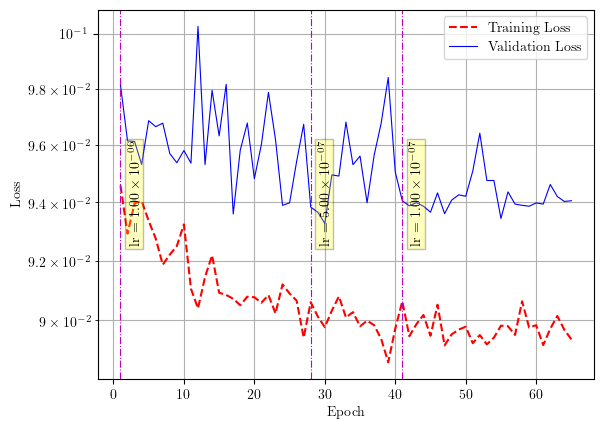

<Figure size 640x480 with 0 Axes>

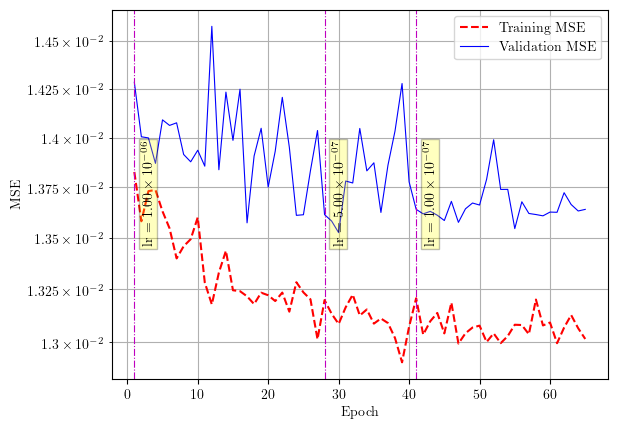

<Figure size 640x480 with 0 Axes>

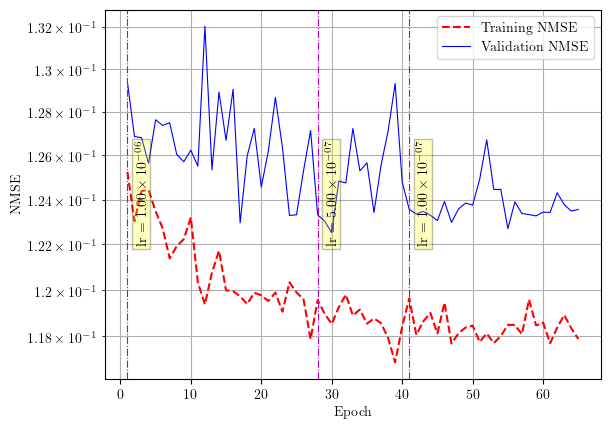

<Figure size 640x480 with 0 Axes>

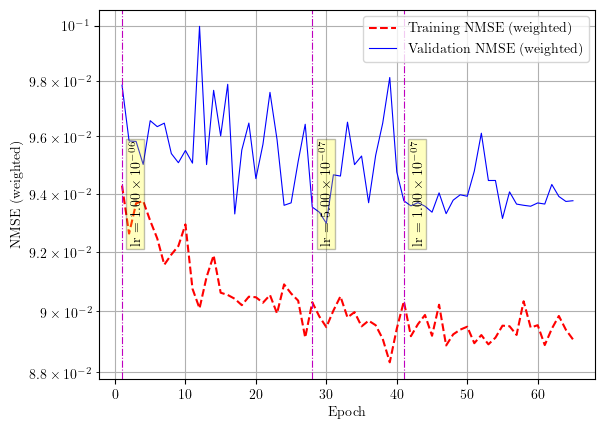

<Figure size 640x480 with 0 Axes>

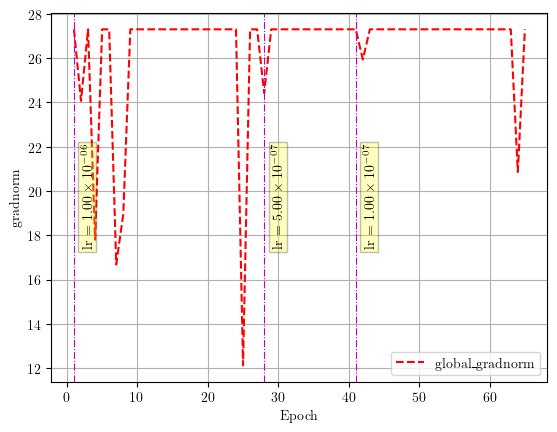

<Figure size 640x480 with 0 Axes>

In [19]:
global_clipnorm = None
for kk in range(len(T_sample_output)):

    num_outsteps = int((T_sample_output[kk] + 0.5*dt_rnn)//dt_rnn)
    if type(freeze_layers) == type(None):
        freeze_layers_thisoutstep = []
    else:
        if kk > len(freeze_layers) - 1:
            freeze_layers_thisoutstep = freeze_layers[-1]
        else:
            freeze_layers_thisoutstep = freeze_layers[kk]
        
        if type(freeze_layers_thisoutstep) == type(None):
            freeze_layers_thisoutstep = []
            
    if type(batch_size) == type([]):
        if kk > len(batch_size) - 1:
            batch_size_thisoutstep = batch_size[-1]
        else:
            batch_size_thisoutstep = batch_size[kk]
    else:
        batch_size_thisoutstep = batch_size

    total_s_len = 80
    sep_lr_s = ' num_outsteps : {} '.format(num_outsteps)
    sep_lr_s = int((total_s_len - len(sep_lr_s))//2)*'>' + sep_lr_s
    sep_lr_s = sep_lr_s + (total_s_len-len(sep_lr_s))*'<'
    print('\n\n' + '*'*len(sep_lr_s))
    print('' + sep_lr_s+'')
    print('*'*len(sep_lr_s) + '\n\n')

    print('clipnorm : {}, global_clipnorm : {}'.format(clipnorm, global_clipnorm))
    
    trainAERNN(
        create_data_for_RNN,
        Autoencoder,
        AR_RNN,
        all_data,
        AR_AERNN,
        dt_rnn=dt_rnn,
        T_sample_input=T_sample_input,
        T_sample_output=T_sample_output[kk],
        T_offset=T_offset,
        boundary_idx_arr=boundary_idx_arr,
        delta_t=delta_t,
        params=params,
        normalize_dataset=normalize_dataset,
        stddev_multiplier=stddev_multiplier,
        skip_intermediate=skip_intermediate,
        normalization_type=normalization_type,
        normalization_constant_arr_aedata=normalization_constant_arr_aedata,
        normalization_constant_arr_rnndata=normalization_arr_rnn,
        learning_rate_list=learning_rate_list[kk],
        epochs=epochs[kk],
        patience=patience[kk],
        loss_weights=loss_weights,
        min_delta=min_delta,
        lambda_reg=lambda_reg,
        stddev_rnn=stddev,
        stateful=False,
        behaviour=behaviour,
        strategy=strategy,
        dir_name_rnn=dir_name_rnn,
        dir_name_AR_AErnn=dir_name_ARrnn,
        batch_size=batch_size_thisoutstep,
        load_file_rnn=load_file_rnn,
        wt_file_rnn=wt_file_rnn,
        load_file_ae=load_file_ae,
        wt_file_ae=wt_file_ae,
        covmat_lmda=covmat_lmda,
        readAndReturnLossHistories=readAndReturnLossHistories,
        mytimecallback=mytimecallback,
        plot_losses=plot_losses,
        SaveLosses=SaveLosses,
        train_split=train_split,
        test_split=test_split,
        val_split=val_split,
        freeze_layers=freeze_layers_thisoutstep,
        clipnorm=clipnorm,
        global_clipnorm=global_clipnorm,
        use_ae_data=use_ae_data,
    )
    
    wt_file_rnn = dir_name_ARrnn+'/final_net/final_net-{}_outsteps_rnn_weights.h5'.format(num_outsteps)
    wt_file_ae = dir_name_ARrnn+'/final_net/final_net-{}_outsteps_ae_weights.h5'.format(num_outsteps)
    
    with open(dir_name_ARrnn+'/final_net/losses-{}_outsteps.txt'.format(num_outsteps), 'r') as fl:
        lines = fl.readlines()

    loss_dict = eval(''.join(lines))
    train_global_gradnorm_hist = loss_dict['train_global_gradnorm_hist']
    # lr_change = loss_dict['lr_change']
    # trained_epochs = len(train_global_gradnorm_hist)
    # if lr_change[-1] - lr_change[-2] == epochs[kk][-1]:
    #     global_clipnorm = train_global_gradnorm_hist[-1]
    # else:
    #     global_clipnorm = train_global_gradnorm_hist[-patience[kk][-1]]

    # alpha1 = 0.9
    # alpha2 = 0.1
    # global_clipnorm = train_global_gradnorm_hist[0]
    # for i in range(1, len(train_global_gradnorm_hist)):
    #     global_clipnorm = alpha1*global_clipnorm + alpha2*train_global_gradnorm_hist[i]

#     grad_norm_decay = 0.95
#     idxs_to_ignore = 0

#     global_clipnorm = np.max(train_global_gradnorm_hist[idxs_to_ignore:])
#     # global_clipnorm = 0.25 * np.round(4*global_clipnorm)
#     global_clipnorm = grad_norm_decay * global_clipnorm
    idxs_to_ignore = 1
    global_clipnorm_min = 3.0
    global_clipnorm = np.max(train_global_gradnorm_hist[idxs_to_ignore:])
    global_clipnorm = 0.1 * np.round(10*global_clipnorm)
    global_clipnorm = max(global_clipnorm, global_clipnorm_min)

In [20]:
a = 123e-5
a

0.00123

In [21]:
s = '{:E}'.format(a)
s

'1.230000E-03'

In [22]:
idx = s.find('E')
num = float(s[0:idx])
10**float(s[idx+1:])

0.001

In [23]:
### Training the combined AE-RNN


# 